# Chat with your own videos with Azure OpenAI GPT-4 Turbo Vision and Azure AI Spatial Analysis Video Retrieval

## Video Analytics usecases

This solution accelerator presents a detailed framework for analyzing videos, leveraging Azure OpenAI GPT4-Vision with Video Enhancements technology.
It's a crucial resource for businesses across a range of industries, including marketing, media, education, manufacturing, healthcare, and retail.

**Azure AI Spatial Analysis Video Retrieval APIs** are part of Azure AI Vision and enable developers to create an index, add documents (videos and images) to it, and search with natural language. Developers can define metadata schemas for each index and ingest metadata to the service to help with retrieval. Developers can also specify what features to extract from the index (vision, speech) and filter their search based on features.

> All credits to: https://github.com/Azure/gen-cv/blob/main/video/README.md

<img src="header.png">

Documentation:
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/video-retrieval
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/reference-video-search
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/gpt-with-vision


> Note: Video retrieval using vectorization is preview (version 4.0 preview)

In [4]:
#%pip install python-docx

In [5]:
import base64
import cv2
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import requests
import sys
import time

from azure.core.credentials import AzureSasCredential
from azure.storage.blob import BlobClient
from docx import Document
from dotenv import load_dotenv
from IPython.display import Video, Markdown, HTML, FileLink
from moviepy.editor import VideoFileClip
from urllib.parse import quote

## 1. Setup

In [6]:
load_dotenv("azure.env")

# 1. Azure OpenAI
AOAI_KEY = os.getenv("AOAI_KEY")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")

# 2. Azure AI Vision
AZURE_CV_KEY = os.getenv("AZURE_CV_KEY")
AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")

# 3. Azure Storage Account
# Check the validatity date and "Add, Create, Write, Delete and List" permissions for the SAS Token
AZURE_SAS_TOKEN = os.getenv("AZURE_SAS_TOKEN")
AZURE_STORAGE_ACCOUNT = os.getenv("AZURE_STORAGE_ACCOUNT")
# Container to store the videos
AZURE_STORAGE_CONTAINER = os.getenv("AZURE_STORAGE_CONTAINER")

In [7]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")


check_openai_version()

Installed OpenAI version: 1.12.0
[OK] OpenAI version 1.12.0 is >= 1.0.0


In [8]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.12.0


In [9]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 26-Feb-2024 10:52:08


In [10]:
pd.set_option("display.max_colwidth", False)

### GPT-4 Turbo with Vision model

In [11]:
GPT_4V_DEPLOYMENT = "gpt-4TurboVision"  # Your GPT4 Turbo Vision deployed model

In [12]:
GPT_4V_ENDPOINT = f"{AOAI_ENDPOINT}/openai/deployments/{GPT_4V_DEPLOYMENT}\
/extensions/chat/completions?api-version=2023-12-01-preview"

### Directories

In [13]:
AZURE_STORAGE_PATH = "samples/"  # Directory to create into your blob storage

VIDEO_DIR = "videos"
VIDEO_INDEX = f"vid-{str(datetime.datetime.today().strftime('%d%b%Y-%H%M%S'))}"

In [14]:
print(f"Index to create: {VIDEO_INDEX}")

Index to create: vid-26Feb2024-105216


## 2. Helper functions

In [93]:
def upload_file_to_blob(blob_name: str, source_dir=VIDEO_DIR, file_extension: str = ""):
    """
    Uploads a file to Azure Blob Storage.

    Args:
        blob_name (str): The name of the blob (file) to be uploaded.
        source_dir (str, optional): The directory of the source file. Defaults to VIDEO_DIR.
        file_extension (str, optional): The file extension (including the dot, e.g., '.mp4') to
        be appended to blob_name. Defaults to ''.

    Returns:
        str: The URL of the uploaded blob.

    """
    account_url = "https://{}.blob.core.windows.net/".format(AZURE_STORAGE_ACCOUNT)

    full_blob_name = os.path.join(AZURE_STORAGE_PATH, blob_name + file_extension)
    encoded_blob_name = quote(full_blob_name)  # URL-encode the full_blob_name

    blob_client = BlobClient(
        account_url=account_url,
        container_name=AZURE_STORAGE_CONTAINER,
        blob_name=full_blob_name,
        credential=AzureSasCredential(AZURE_SAS_TOKEN),
        max_block_size=1024 * 1024 * 4,  # 4 MiB
        max_single_put_size=1024 * 1024 * 16,  # 16 MiB
    )

    with open(
        file=os.path.join(source_dir, blob_name + file_extension), mode="rb"
    ) as data:
        blob_client.upload_blob(data=data, overwrite=True, max_concurrency=2)

    return account_url + AZURE_STORAGE_CONTAINER + "/" + encoded_blob_name


def local_videos_to_azure_blob(file_path, video_dir=VIDEO_DIR):
    """
    Upload local videos to Azure Storage Account
    """
    video_path = os.path.join(video_dir, file_path)

    # extract metadata from video file
    with VideoFileClip(video_path) as video:
        duration_mins = round(video.duration / 60, 1)  # Duration in minutes
        fps = round(video.fps)  # Frames per second
        resolution = video.size  # Resolution (width, height)

    file_size_bytes = os.path.getsize(video_path)
    size_mb = round(file_size_bytes / (1024 * 1024), 1)

    # upload video file to blob storage
    blob_url = upload_file_to_blob(file_path, video_dir)

    metadata = {
        "duration_mins": duration_mins,
        "fps": fps,
        "resolution": resolution,
        "document_url": blob_url,
        "size_mb": size_mb,
    }

    return metadata


def list_video_indexes(vision_api_endpoint, vision_api_key):
    """
    List indexes
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    response = requests.get(url, headers=headers)

    return response.json()


def delete_video_index(vision_api_endpoint, vision_api_key, index_name):
    """
    Delete video index
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    response = requests.delete(url, headers=headers)

    return response


def create_video_index(vision_api_endpoint, vision_api_key, index_name, metadata=False):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    data = {"features": [{"name": "vision", "domain": "generic"}, {"name": "speech"}]}

    if metadata:
        data["metadataSchema"] = metadata
    response = requests.put(url, headers=headers, json=data)

    return response


def get_indexed_video_documents(vision_api_endpoint, vision_api_key, index_name):
    """
    Get indexed videos
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/documents?api-version=2023-05-01-preview&$top=30"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key
    }  # , "Content-Type": "application/json"}
    response = requests.get(url, headers=headers)

    return response


def find_scene(queryText="", featureFilters=["vision", "speech"]):
    """
    Searches text over vision and/or speech features of an indexed video. It is also called frame locator or video
    retrieval api.
    It returns the relevant frames based on the text input and adname.

    Args:
        queryText: Free text input to search in "vision" and "speech" features
        featureFilters: Video features to search a given text, it is possible to select both or only one of "vision"
        and "speech"
    Returns:
        query_result : Response returned from video retrieval api, which is a list of most relevant frames with their
        confidence scores.
    """
    #AZURE_CV_API_VERSION = os.getenv("AZURE_CV_API_VERSION")

    url = (
        AZURE_CV_ENDPOINT
        + "/computervision/retrieval/indexes/"
        + VIDEO_INDEX
        + ":queryByText?api-version=2023-05-01-preview"
    )

    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    }

    body = {
        "queryText": queryText,
        "dedup": True,
        "filters": {"featureFilters": featureFilters},
    }

    query_result = None

    try:
        r = requests.post(url, json=body, headers=headers)
        query_result = r.json()
    except Exception as error:
        print("Video search operation failed ")
        print(error)

    return query_result


def extract_frame(video_path, timestamp):
    """
    Extract a frame from a video at a given timestamp.
    """
    try:
        # Handle timestamps with fractional seconds
        h, m, s = timestamp.split(":")
        s, ms = (s.split(".") + ["0"])[
            :2
        ]  # Split seconds and milliseconds, default ms to '0' if not present
        frame_time = (int(h) * 3600 + int(m) * 60 + int(s)) * 1000 + int(
            ms[:3]
        )  # Convert to milliseconds

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time)

        success, frame = cap.read()

        if success:
            return cv2.cvtColor(
                frame, cv2.COLOR_BGR2RGB
            )  # Convert color to RGB for matplotlib

    except Exception as e:
        print(f"Error extracting frame: {e}")

    return None


def video_chat(
    video_url,
    document_id,
    user_prompt,
    sas_token=AZURE_SAS_TOKEN,
    video_index=VIDEO_INDEX,
    gpt_4v_endpoint=GPT_4V_ENDPOINT,
    openai_api_key=AOAI_KEY,
    azure_cv_endpoint=AZURE_CV_ENDPOINT,
    azure_cv_key=AZURE_CV_KEY,
):
    """
    Video chat using Azure OpenAI GPT-4 Turbo with Vision and Azure AI Vision
    """
    headers = {"Content-Type": "application/json", "api-key": openai_api_key}

    payload = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"video": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVisionVideoIndex",
                "parameters": {
                    "computerVisionBaseUrl": f"{azure_cv_endpoint}/computervision",
                    "computerVisionApiKey": azure_cv_key,
                    "indexName": video_index,
                    "videoUrls": [f"{video_url}?{sas_token}"],
                },
            }
        ],
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant to analyze images and videos",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {"type": "acv_document_id", "acv_document_id": document_id},
                ],
            },
        ],
        "max_tokens": 1000,
        "temperature": 0,
        "seed": 1,
    }

    try:
        response = requests.post(gpt_4v_endpoint, headers=headers, json=payload)
        response.raise_for_status()
        content = response.json()["choices"][0]["message"]["content"]
        return content

    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")


def display_tiles(matches_df, nrows=2, ncols=3, figsize=(16, 9)):
    """
    Display videos tiles
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=100)
    axes = axes.flatten()

    for i, (ax, (_, row)) in enumerate(zip(axes, matches_df.iterrows())):
        row = row["value"]
        video_path = f"{VIDEO_DIR}/{row['documentId']}"
        timestamp = row["best"]
        frame = extract_frame(video_path, timestamp)

        if frame is not None:
            ax.imshow(frame)
        else:
            ax.imshow(
                np.zeros((100, 100, 3), dtype=np.uint8)
            )  # Display an empty black frame

        title = f"Top {i+1}, (score: {row['relevance']:.3f}) - Video id: {row['documentId']}"

        # Adjusting the timestamp format to remove sub-second information
        start = row["start"].split(".")[0] if "start" in row else None
        end = row["end"].split(".")[0] if "end" in row else None
        subtitle = f"{start} - {end}" if start and end else "Timestamp not available"

        ax.set_title(f"{title}\n{subtitle}", fontsize=10, pad=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def image_to_html(image, format="jpeg"):
    """
    Image to HTML
    """
    buffer = io.BytesIO()
    plt.imsave(buffer, image, format=format)
    data_uri = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return f'<img src="data:image/{format};base64,{data_uri}" width="200">'


def index_video(video):
    """
    Function to structure video data for indexing
    """
    return {
        "mode": "add",
        "documentId": video["id"],
        "documentUrl": video["document_url"] + "?" + AZURE_SAS_TOKEN,
        "metadata": {
            "filename": video["filename"],
            "duration_mins": str(video["duration_mins"]),
            "size_mb": str(video["size_mb"]),
            "resolution": str(video["resolution"]),
            "fps": str(video["fps"]),
        },
    }


def get_indexes():
    """
    List of existing indexes
    """
    print("List of existing indexes:")
    indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
    index_names = [index["name"] for index in indexes["value"]]
    print(index_names)

    return index_names


def delete_index(index_to_delete):
    """
    Delete index
    """
    print(f"Deleting the index {index_to_delete}")
    response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, index_to_delete)

    if response.status_code == 204:
        print("Done")
    else:
        print("Error")

## 3. Examples

In [16]:
!ls $VIDEO_DIR/*.* -lh

-rwxrwxrwx 1 root root  14M Jan 29 15:44 'videos/Azure AI Studio Demo.mp4'
-rwxrwxrwx 1 root root  12M Jan 26 13:00 'videos/Azure VMware Solution.mp4'
-rwxrwxrwx 1 root root 7.3M Jan 29 15:43 'videos/Azure text to speech avatar.mp4'
-rwxrwxrwx 1 root root  22M Jan 26 13:00 'videos/GPT-4 Turbo with Azure AI.mp4'
-rwxrwxrwx 1 root root 4.6M Jan 26 14:00 'videos/Paris Jeux olympiques 2024.mp4'


In [17]:
video_files = [
    filename for filename in os.listdir(VIDEO_DIR) if filename.lower().endswith(".mp4")
]

# Create DataFrame with id column from video files
video_df = pd.DataFrame({"id": video_files})

# Apply the local_videos_to_azure_blob function directly
metadata_df = video_df["id"].apply(local_videos_to_azure_blob)

# Convert the dictionary to a DataFrame and join with the original DataFrame
metadata_df = pd.DataFrame(metadata_df.tolist())
video_df = video_df.join(metadata_df)
video_df["filename"] = video_df["id"]

display(video_df)

id  duration_mins  fps   resolution  \
0  Azure AI Studio Demo.mp4         1.5            30   [1280, 720]   
1  Azure text to speech avatar.mp4  1.8            30   [1280, 720]   
2  Azure VMware Solution.mp4        2.8            30   [1280, 720]   
3  GPT-4 Turbo with Azure AI.mp4    8.7            30   [640, 360]    
4  Paris Jeux olympiques 2024.mp4   1.0            25   [640, 360]    

                                                                                                 document_url  \
0  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20AI%20Studio%20Demo.mp4            
1  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20text%20to%20speech%20avatar.mp4   
2  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20VMware%20Solution.mp4             
3  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/GPT-4%20Turbo%20with%20Azure%20AI.mp4     
4  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Paris%20Jeux%20olympiques%202024.mp4      

   size_mb                         filename  
0  13.7     Azure AI Studio Demo.mp4         
1  7.2      Azure text to speech avatar.mp4  
2  11.5     Azure VMware Solution.mp4        
3  21.3     GPT-4 Turbo with Azure AI.mp4    
4  4.5      Paris Jeux olympiques 2024.mp4

In [18]:
# list existing indexes
indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
index_names = [index["name"] for index in indexes["value"]]

In [19]:
# Delete existing index
print("Deleting the index...")
response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)
print(response.text)
print("Status code:", response.status_code)  # 204 expected
print("\nDone")

Deleting the index...

Status code: 204

Done


In [20]:
print("Creating the index...\n")

# define additional metadata information
metadata = {
    "language": "en",
    "fields": [
        {"name": "filename", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "duration_mins",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "size_mb", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "resolution",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "fps", "searchable": False, "filterable": True, "type": "string"},
    ],
}

# create index
response = create_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX, metadata)

print(f"Status code: {response.status_code}\n")
print(response.text)
print("\nDone")

Creating the index...

Status code: 201

{"name":"vid-26feb2024-105216","metadataSchema":{"language":"en","fields":[{"name":"filename","searchable":false,"filterable":true,"type":"string"},{"name":"duration_mins","searchable":false,"filterable":true,"type":"string"},{"name":"size_mb","searchable":false,"filterable":true,"type":"string"},{"name":"resolution","searchable":false,"filterable":true,"type":"string"},{"name":"fps","searchable":false,"filterable":true,"type":"string"}]},"userData":{},"features":[{"name":"vision","modelVersion":"2022-04-11","domain":"generic"},{"name":"speech","modelVersion":"2023-06-30","domain":"generic"}],"eTag":"\"e107e9155d544e7e932f5456d6540ab4\"","createdDateTime":"2024-02-26T10:52:36.3796804Z","lastModifiedDateTime":"2024-02-26T10:52:36.3796804Z"}

Done


In [21]:
INGESTION_NAME = f"{VIDEO_INDEX}-ingestion"

url = f"{AZURE_CV_ENDPOINT}/computervision/retrieval/indexes/{VIDEO_INDEX}/ingestions/{INGESTION_NAME}?api-version=2023-05-01-preview"
headers = {
    "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    "Content-Type": "application/json",
}

videos = [index_video(video) for _, video in video_df.iterrows()]
body = {"videos": videos, "includeSpeechTranscript": True, "moderation": False}

r = requests.put(url, json=body, headers=headers)
result = r.json()
result

{'name': 'vid-26feb2024-105216-ingestion',
 'state': 'Running',
 'batchName': '52fb513f-2a74-4ec8-8465-fd0ef71558b9',
 'createdDateTime': '2024-02-26T10:52:39.7233743Z',
 'lastModifiedDateTime': '2024-02-26T10:52:40.1452374Z'}


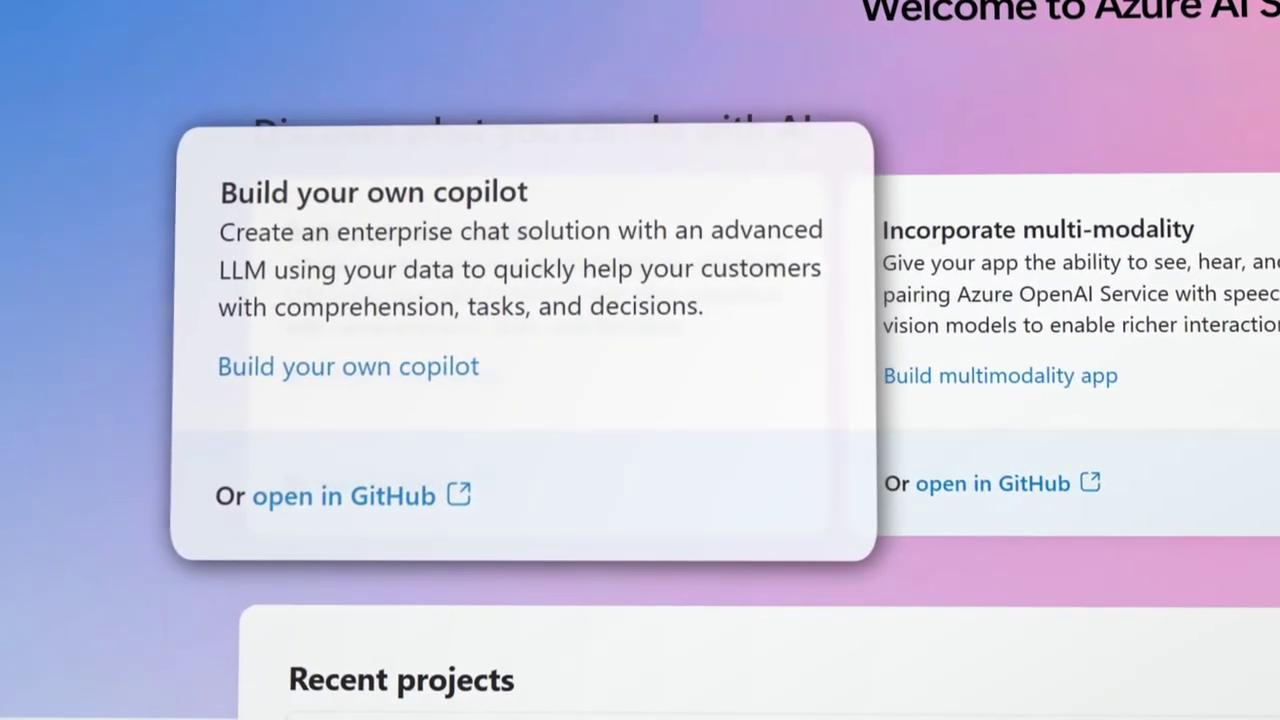
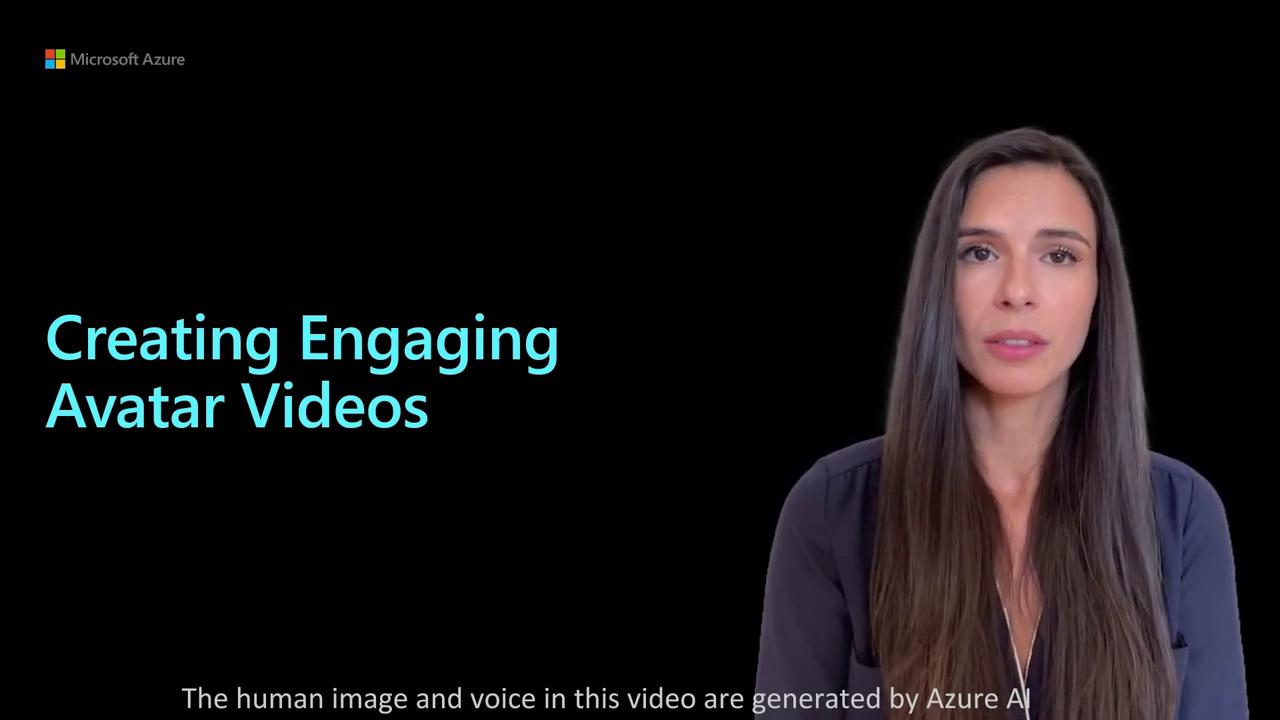
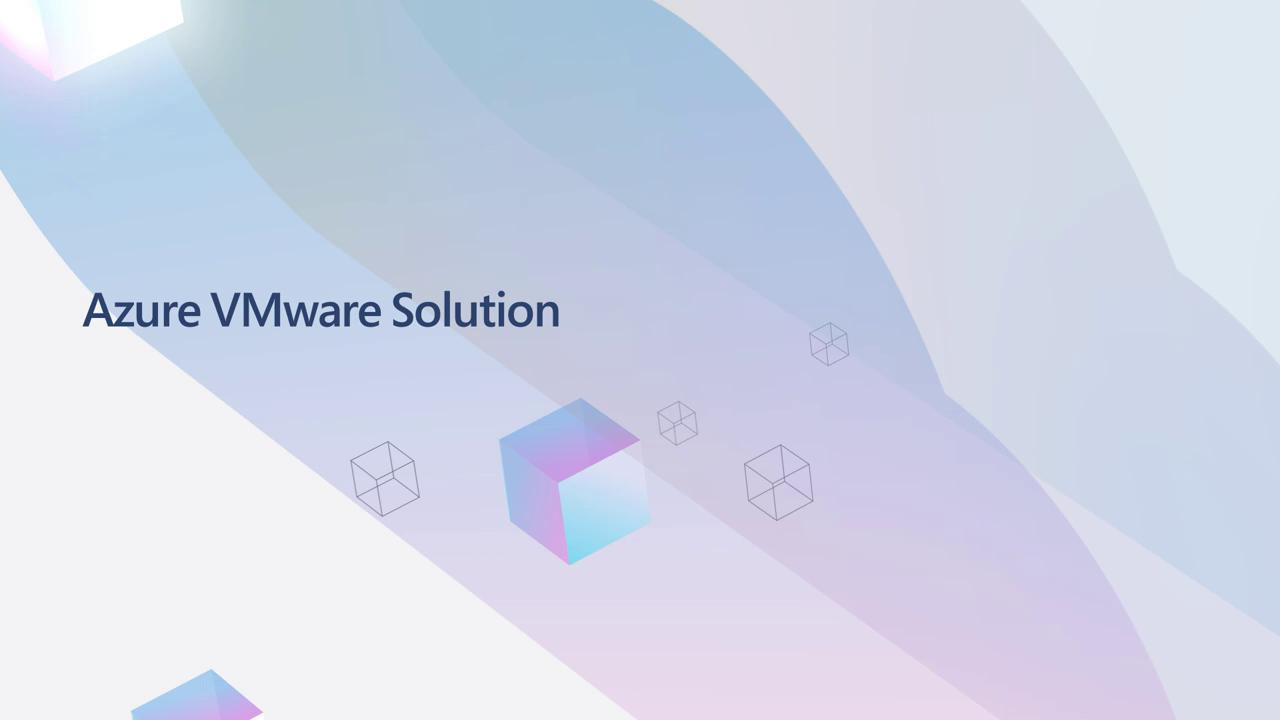
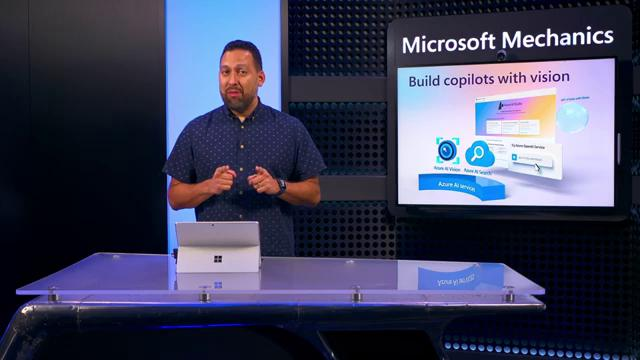
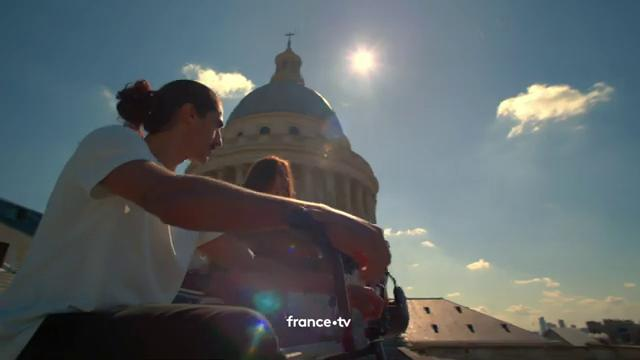

In [22]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df = pd.DataFrame.from_records(response.json()["value"])
metadata_fields = pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df = pd.concat([indexed_videos_df, metadata_fields], axis=1)
del indexed_videos_df["metadata"]

# Generate thumbnails and add them to the df
thumbnails = []

for url in indexed_videos_df["documentUrl"]:
    video_url = url + "?" + AZURE_SAS_TOKEN
    thumbnail = extract_frame(video_url, "00:00:10")
    thumbnails.append(image_to_html(thumbnail) if thumbnail is not None else "")

indexed_videos_df["thumbnail"] = thumbnails

# Create HTML table
html_table = indexed_videos_df[
    [
        "thumbnail",
        "filename",
        "duration_mins",
        "size_mb",
        "resolution",
        "fps",
        "createdDateTime",
        "documentUrl",
    ]
].copy()
html_table = html_table.to_html(escape=False)

display(HTML(html_table))

### Display some videos

In [23]:
video_files

['Azure AI Studio Demo.mp4',
 'Azure text to speech avatar.mp4',
 'Azure VMware Solution.mp4',
 'GPT-4 Turbo with Azure AI.mp4',
 'Paris Jeux olympiques 2024.mp4']

In [24]:
video_file = os.path.join(VIDEO_DIR, video_files[0])

print(f"Video file: {video_file}")
Video(video_file, width=640)

Video file: videos/Azure AI Studio Demo.mp4


In [25]:
video_file = os.path.join(VIDEO_DIR, video_files[4])

print(f"Video file: {video_file}")
Video(video_file, width=640)

Video file: videos/Paris Jeux olympiques 2024.mp4


## 4. Chat with your own videos

The more specific your search term is, the better tend to be the search results. 

In [102]:
def chat_with_your_own_videos(query, vision_only=False):
    """
    Chat with your own videos using speech and/or vision
    """
    features = ["vision"] if vision_only else ["speech", "vision"]

    search_results = find_scene(queryText=query, featureFilters=features)   #["value"]
    df = pd.DataFrame.from_records(search_results).head(10)
    display_tiles(df)

    return df

### Examples

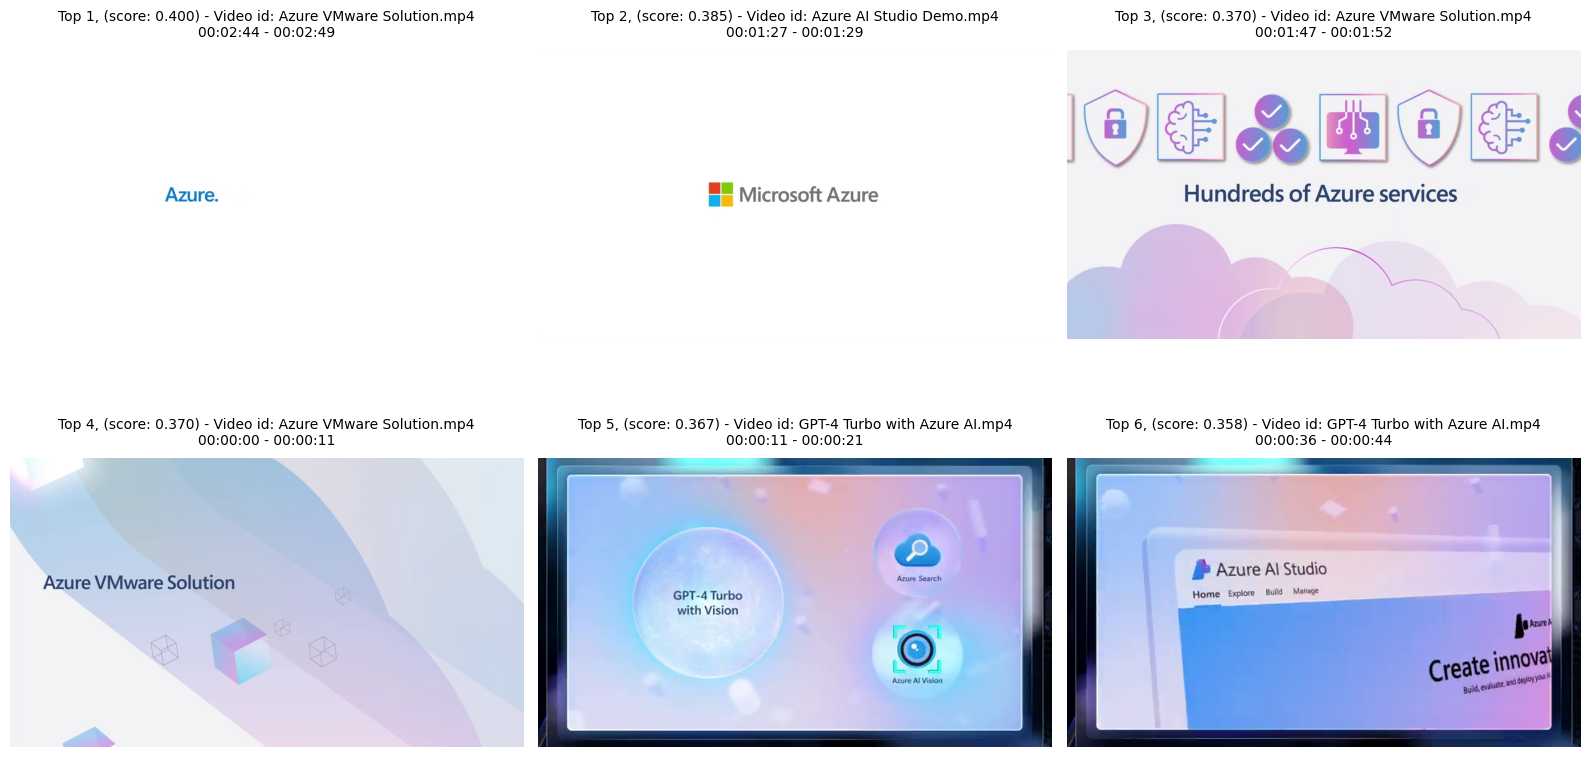

In [103]:
# search in video track only
query = "Azure"
df = chat_with_your_own_videos(query, vision_only=True)

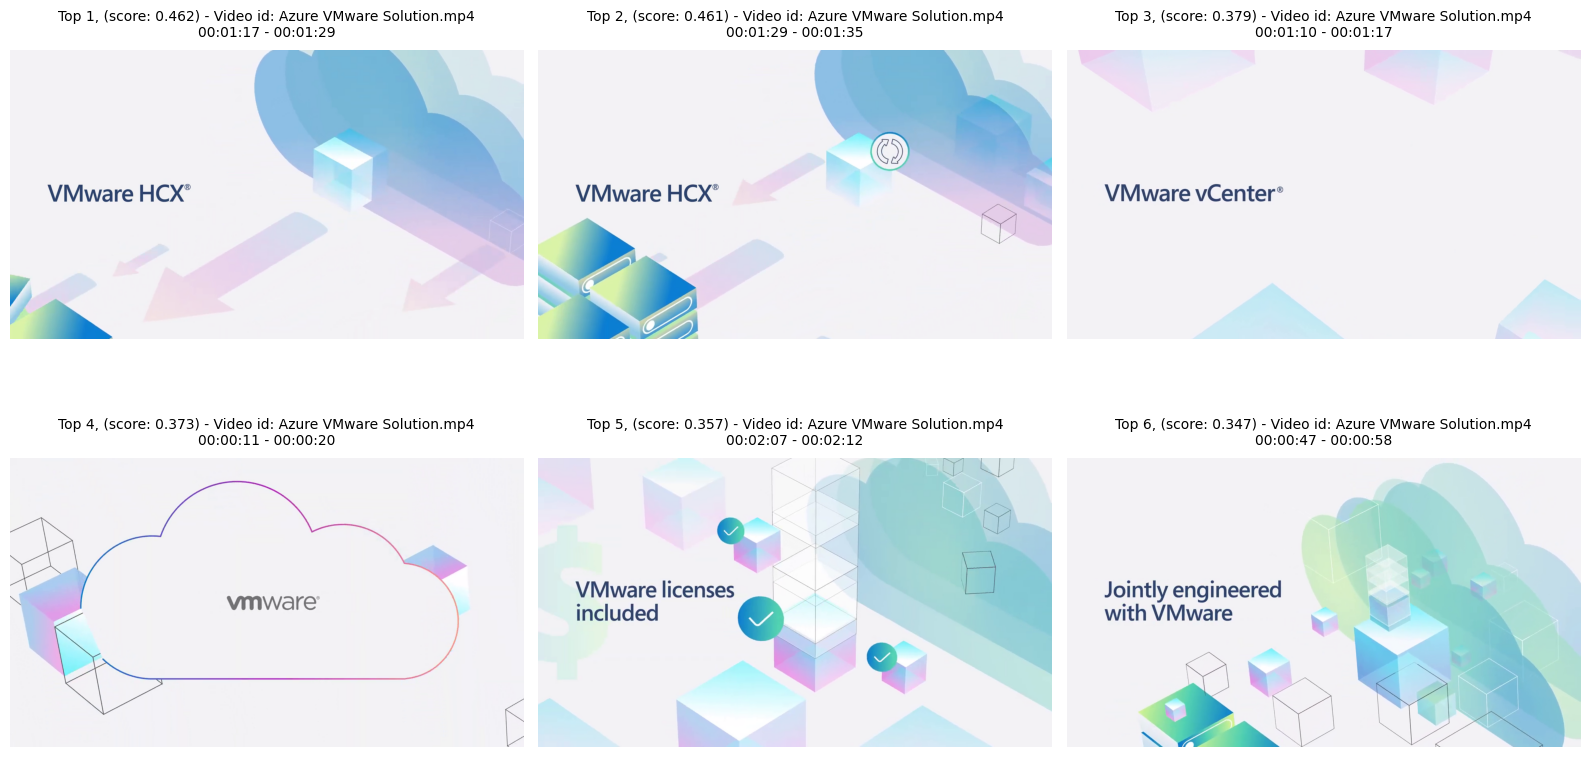

In [104]:
# search in video track only
query = "vmware HCX"
df = chat_with_your_own_videos(query, vision_only=True)

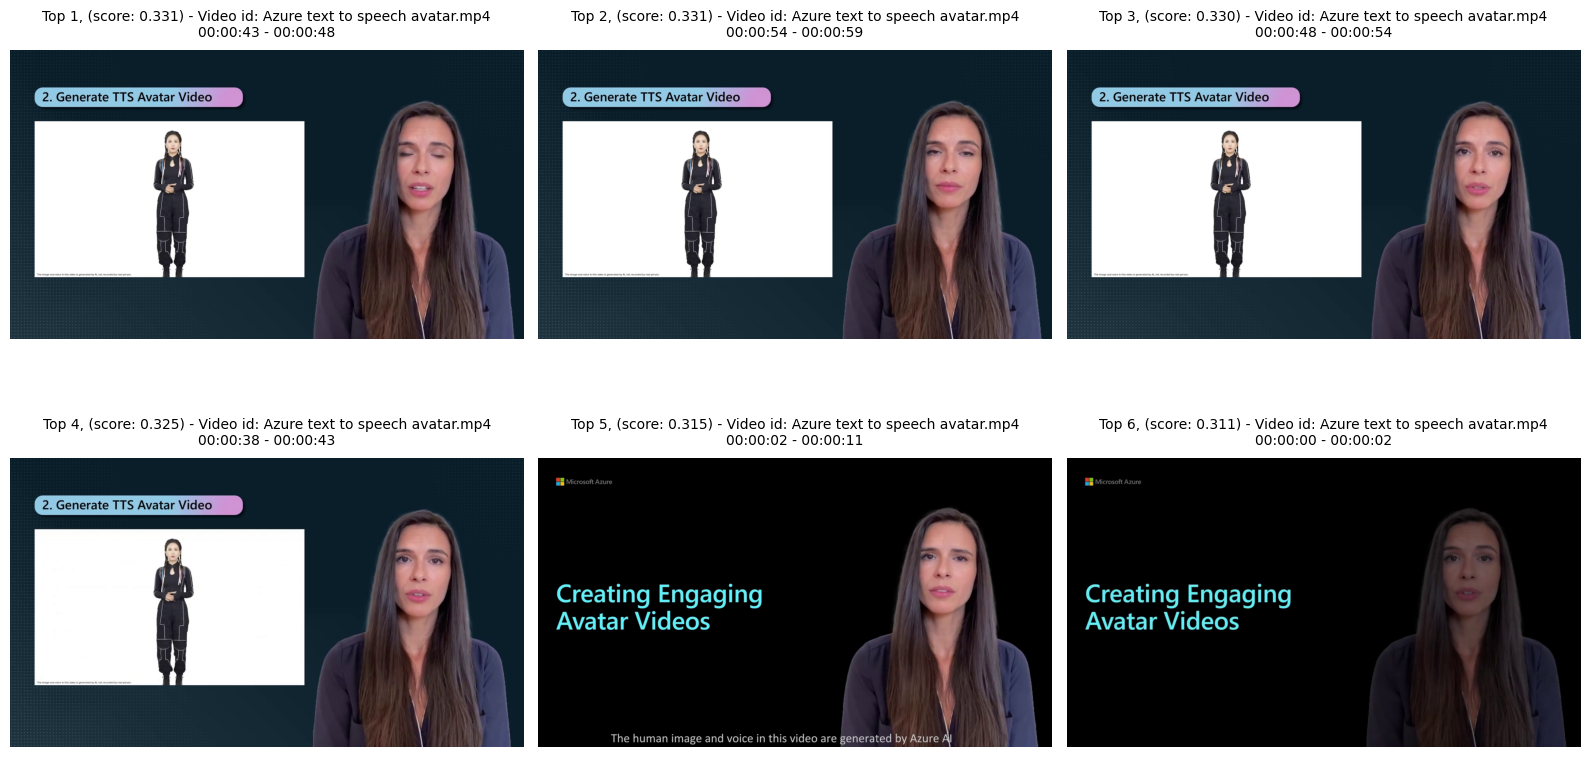

In [105]:
# search in audio and video tracks
query = "Avatar"
df = chat_with_your_own_videos(query, vision_only=False)

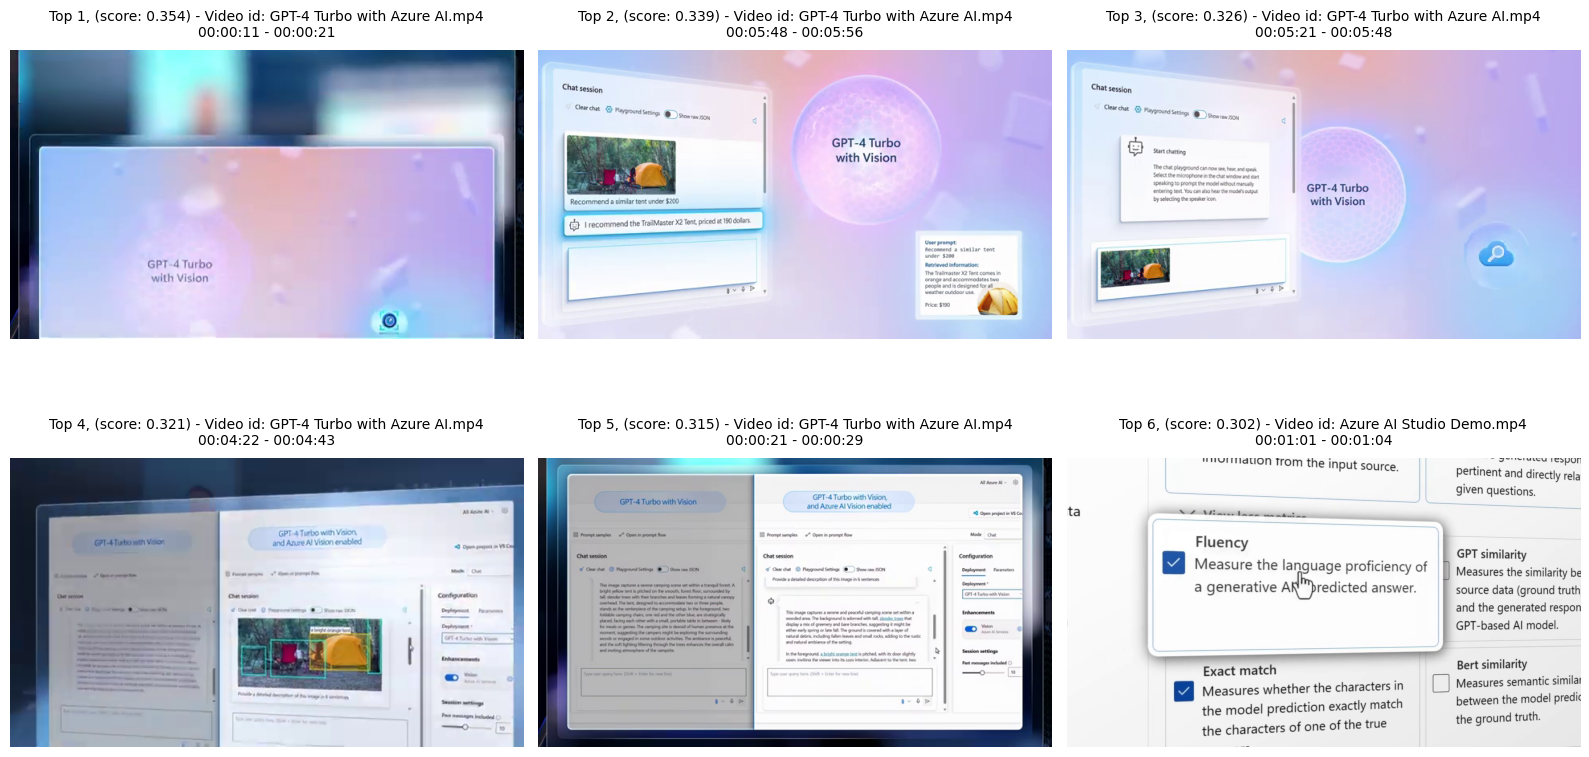

In [106]:
# search in audio and video tracks
query = "GPT-4"
df = chat_with_your_own_videos(query, vision_only=False)

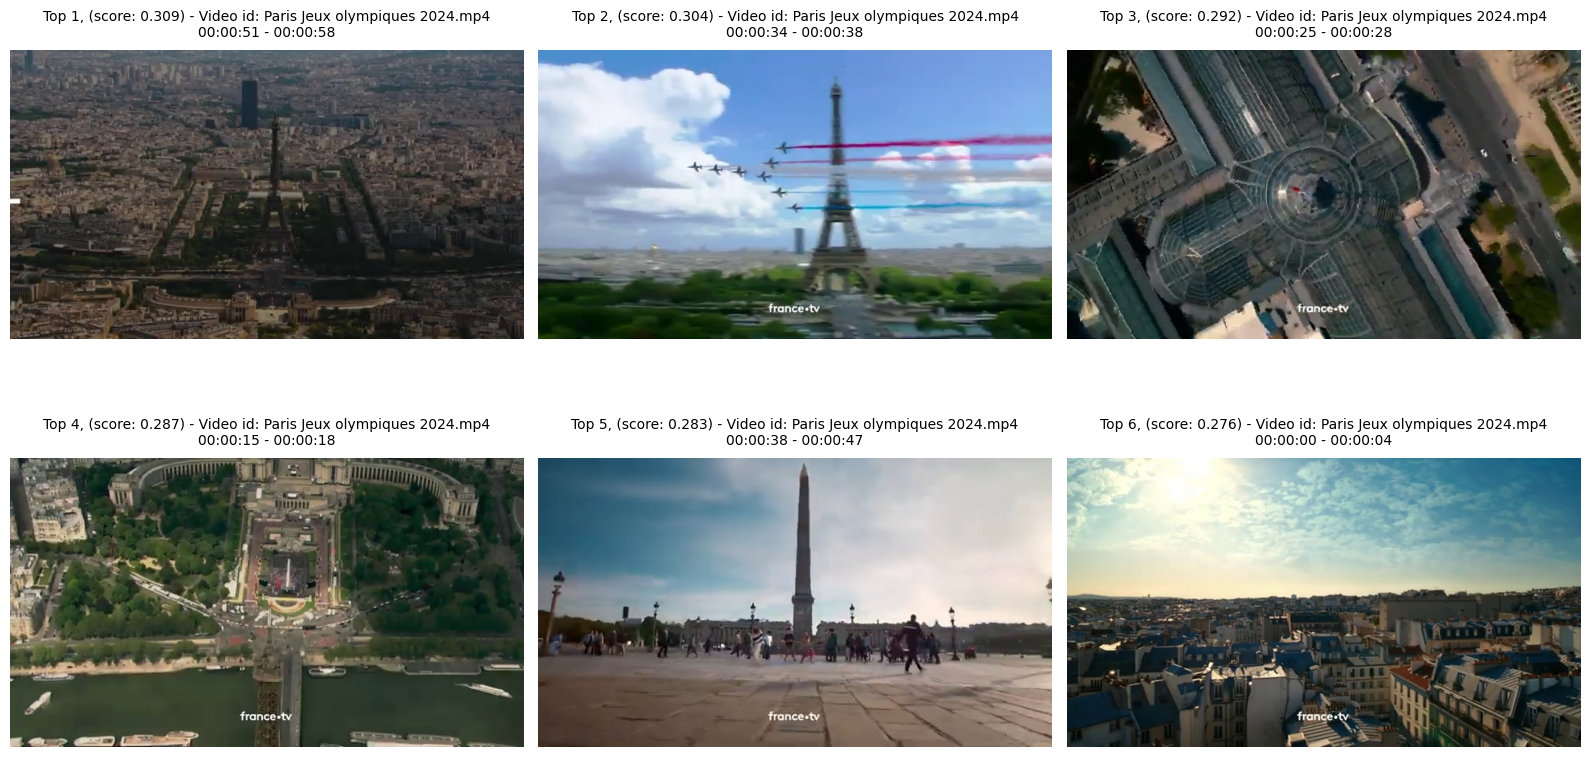

In [107]:
# search in audio and video tracks
query = "Eiffel tower"
df = chat_with_your_own_videos(query, vision_only=False)

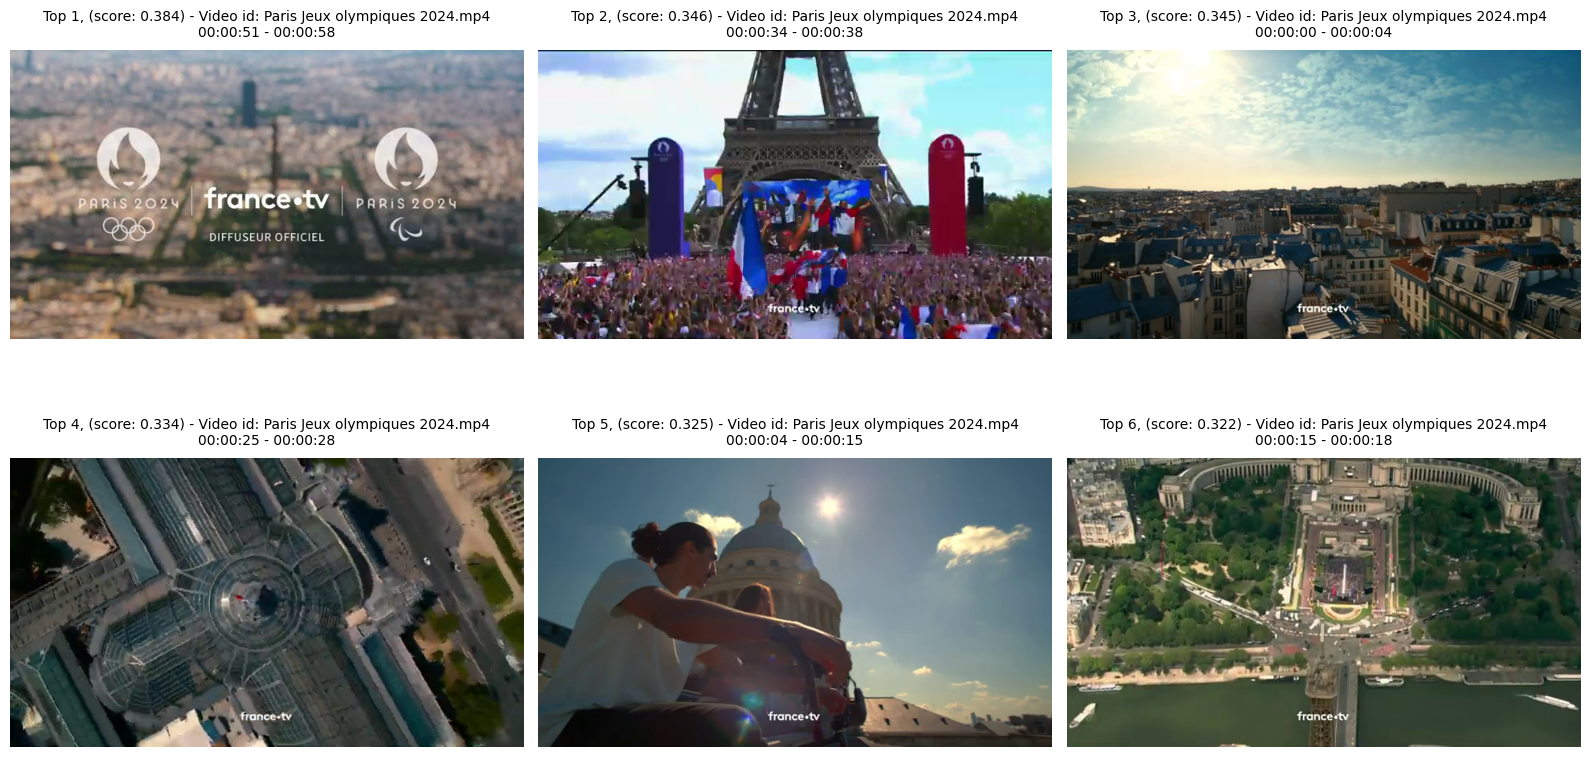

In [108]:
# search in audio and video tracks
query = "France TV"
df = chat_with_your_own_videos(query, vision_only=False)

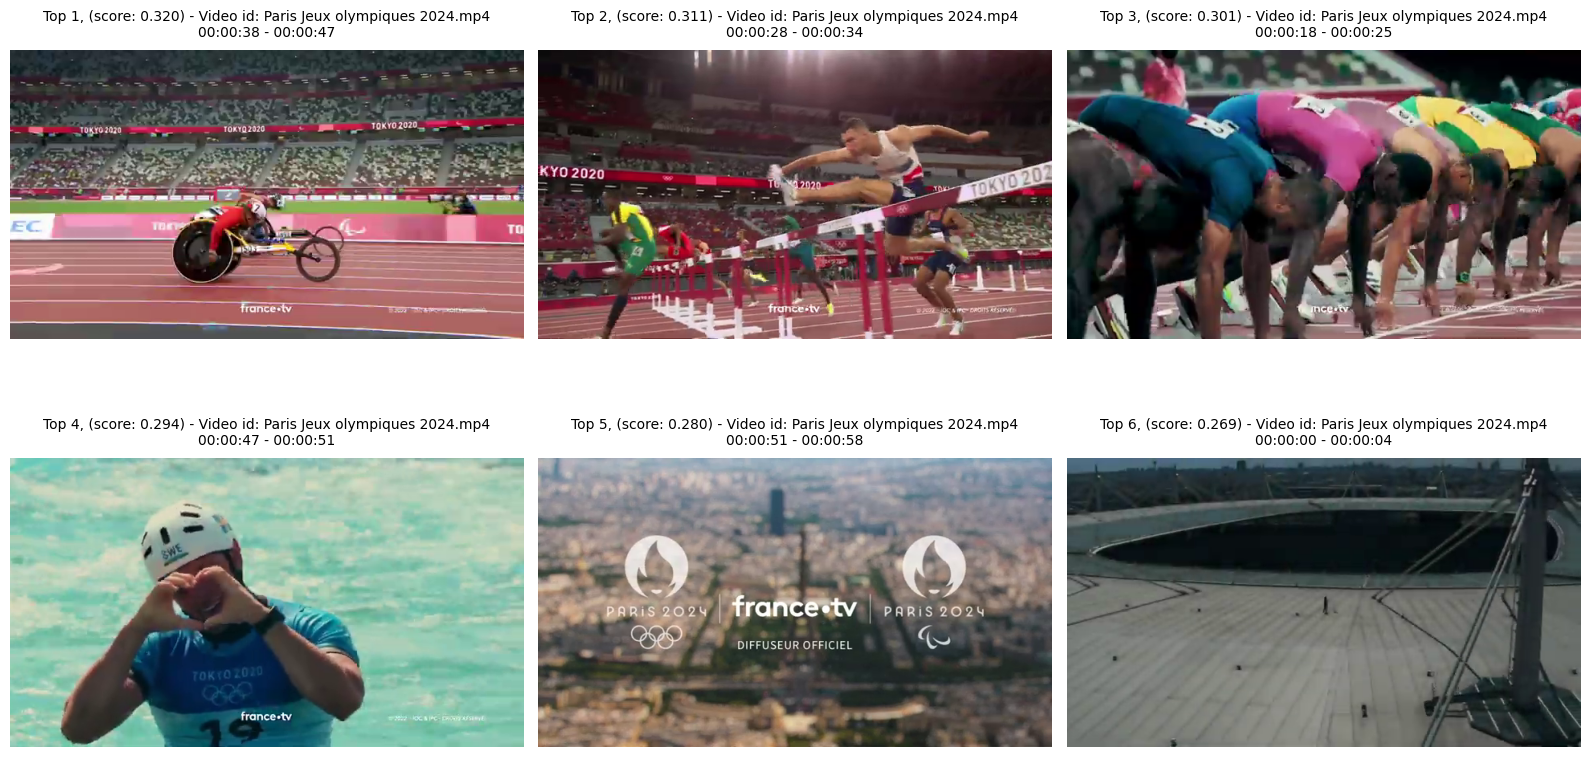

In [109]:
# search in audio and video tracks
query = "Olympic Games"
df = chat_with_your_own_videos(query, vision_only=False)

## 5. Chat based video analysis

In [33]:
video_files

['Azure AI Studio Demo.mp4',
 'Azure text to speech avatar.mp4',
 'Azure VMware Solution.mp4',
 'GPT-4 Turbo with Azure AI.mp4',
 'Paris Jeux olympiques 2024.mp4']

### Example 1

In [50]:
top_match_id = "Azure AI Studio Demo.mp4"

video_url = indexed_videos_df[indexed_videos_df["documentId"] == top_match_id][
    "documentUrl"
].values[0]

video_url_sas = video_url + "?" + AZURE_SAS_TOKEN

display(
    Video(
        video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"
    )
)

In [51]:
questions = [
    "Provide a summary of the video:",
    "Show a markdown table with timestamps and detailed descriptions of the scenes:",
    "Do we have any brand in the video?",
]

for question in questions:
    print(f"Question: {question}")
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    print("\033[1;31;34m")
    print(response)
    print("\033[0m")

Question: Provide a summary of the video:

The video appears to be a demonstration or promotional content related to Microsoft's Azure AI services. It starts with a graphic animation, then transitions to various screenshots of the Azure AI interface, showcasing different features such as model catalog, responsible AI, data integration, and development tools. The frames show different aspects of the AI service, including browsing models, setting up AI assistants, integrating data sources, creating workflows, evaluating model performance, and content filtering. The video also highlights the ability to open projects in Visual Studio Code and mentions speech analytics towards the end. The final frame displays the Microsoft logo, suggesting that the video is an official Microsoft release, likely intended to inform viewers about the capabilities and user interface of Azure AI services.

Question: Show a markdown table with timestamps and detailed descriptions of the scenes:

| Timestamp     

### Example 2

In [52]:
top_match_id = "Paris Jeux olympiques 2024.mp4"

video_url = indexed_videos_df[indexed_videos_df["documentId"] == top_match_id][
    "documentUrl"
].values[0]

video_url_sas = video_url + "?" + AZURE_SAS_TOKEN

display(
    Video(
        video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"
    )
)

In [53]:
questions = [
    "Provide a summary of the video:",
    "Show a markdown table with timestamps and detailed descriptions of the scenes:",
    "Do we have any landsmarks or famous places in the video?",
    "What are the differents sports in the video?",
    "What are the text displayed on the video?",
]

for question in questions:
    print(f"Question: {question}")
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    print("\033[1;31;34m")
    print(response)
    print("\033[0m")

Question: Provide a summary of the video:

The video appears to be a montage showcasing various scenes, likely from a sports event or a series of events. The first frame shows an expansive view of a large stadium or arena, indicating the potential scale of the event. The second frame is dark with the logo "france-tv," suggesting it might be a broadcast from a French television network.

The third frame captures a beautiful aerial view of a grand building with a dome, which could be a landmark in a French city, possibly Paris, given the architecture. The fourth frame shows an athlete in mid-action during a high jump event, indicating the sports theme of the video.

The fifth frame provides another aerial view of a historic building with a circular roof, again hinting at the cultural richness of the location. The sixth frame captures a moment from a badminton match, adding to the variety of sports being showcased.

The seventh frame is an aerial shot of a landscape with buildings, possib

### Example 3

In [54]:
top_match_id = "Azure text to speech avatar.mp4"

video_url = indexed_videos_df[indexed_videos_df["documentId"] == top_match_id][
    "documentUrl"
].values[0]

video_url_sas = video_url + "?" + AZURE_SAS_TOKEN

display(
    Video(
        video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"
    )
)

In [55]:
questions = [
    "Provide a summary of the video:",
    "Show a markdown table with timestamps and detailed descriptions of the scenes:",
    "What is the language in the video?",
]

for question in questions:
    print(f"Question: {question}")
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    print("\033[1;31;34m")
    print(response)
    print("\033[0m")

Question: Provide a summary of the video:

The video appears to be a tutorial on "Creating Engaging Avatar Videos" using Microsoft Azure's AI technology. It seems to guide viewers through a step-by-step process, which includes:

1. Creating an Avatar Talking Script: The video likely demonstrates how to write a script that an avatar will deliver, possibly showing a text editor or scriptwriting software.

2. Generating TTS (Text-to-Speech) Avatar Video: The video may show how to turn the written script into a spoken video using an avatar, indicating the use of text-to-speech technology.

3. Creating Content Video: This part of the video probably focuses on how to create the content that will go along with the avatar's speech, which might include additional visuals, text, or other multimedia elements.

4. Composing Final Video: The final step likely involves putting all the elements together to create the final video product, possibly using video editing software.

The last frame suggests

In [56]:
questions = [
    "Provide a summary of the video in French:",
]

for question in questions:
    print(f"Question: {question}")
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    print("\033[1;31;34m")
    print(response)
    print("\033[0m")

Question: Provide a summary of the video in French:

La vidéo semble être un tutoriel sur la création de vidéos d'avatar engageantes. Elle se déroule en plusieurs étapes clés :

1. Création d'un script de dialogue pour l'avatar, où l'on voit un document texte avec un script écrit.
2. Génération d'une vidéo TTS (text-to-speech) d'avatar, où l'on aperçoit un avatar animé qui parle.
3. Création d'une vidéo de contenu, avec un aperçu d'un document de traitement de texte contenant des informations sur la vidéo à produire.
4. Composition de la vidéo finale, où l'on voit un logiciel de montage vidéo avec la vidéo de l'avatar intégrée dans un projet.

La dernière image montre une phrase qui encourage à créer de grandes expériences, suggérant que le but de la vidéo est d'enseigner comment produire des vidéos d'avatar de haute qualité pour améliorer l'engagement du spectateur.



## 6. Systematic analysis of multiple videos

In [42]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df = pd.DataFrame.from_records(response.json()["value"])
metadata_fields = pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df = pd.concat([indexed_videos_df, metadata_fields], axis=1)
del indexed_videos_df["metadata"]
analysis_df = indexed_videos_df[["documentId", "filename", "documentUrl"]].copy()

display(analysis_df.head())

documentId                         filename  \
0  Azure AI Studio Demo.mp4         Azure AI Studio Demo.mp4          
1  Azure text to speech avatar.mp4  Azure text to speech avatar.mp4   
2  Azure VMware Solution.mp4        Azure VMware Solution.mp4         
3  GPT-4 Turbo with Azure AI.mp4    GPT-4 Turbo with Azure AI.mp4     
4  Paris Jeux olympiques 2024.mp4   Paris Jeux olympiques 2024.mp4    

                                                                                                  documentUrl  
0  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20AI%20Studio%20Demo.mp4           
1  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20text%20to%20speech%20avatar.mp4  
2  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20VMware%20Solution.mp4            
3  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/GPT-4%20Turbo%20with%20Azure%20AI.mp4    
4  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Paris%20Jeux%20olympiques%202024.mp4

We are going to keep only videos about Azure:

In [43]:
sample_df = analysis_df.head(4)
sample_df

documentId                         filename  \
0  Azure AI Studio Demo.mp4         Azure AI Studio Demo.mp4          
1  Azure text to speech avatar.mp4  Azure text to speech avatar.mp4   
2  Azure VMware Solution.mp4        Azure VMware Solution.mp4         
3  GPT-4 Turbo with Azure AI.mp4    GPT-4 Turbo with Azure AI.mp4     

                                                                                                  documentUrl  
0  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20AI%20Studio%20Demo.mp4           
1  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20text%20to%20speech%20avatar.mp4  
2  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20VMware%20Solution.mp4            
3  https://azurestorageaccountsr.blob.core.windows.net/videos/samples/GPT-4%20Turbo%20with%20Azure%20AI.mp4

In [44]:
questions = {
    "1_products": "What is the name of the main product or technology discussed in this video?",
    "2_use_cases": "What are the key use-cases of the discussed product or technology? Provide them as a short list.",
    "3_details": "Describe the technology specifics of the product or topic in detail.",
    "4_classification": "Is it about AI? Just answer YES or NO.",
}

print("Running the analysis...\n")
i = 1

for column, question in questions.items():
    print(f"Processing question {i}: {question}")
    i += 1
    sample_df[column] = sample_df.apply(
        lambda row: video_chat(
            video_url=row["documentUrl"],
            document_id=row["documentId"],
            user_prompt=question,
        ),
        axis=1,
    )

print("\nDone")

Running the analysis...

Processing question 1: What is the name of the main product or technology discussed in this video?
Processing question 2: What are the key use-cases of the discussed product or technology? Provide them as a short list.
Processing question 3: Describe the technology specifics of the product or topic in detail.
Processing question 4: Is it about AI? Just answer YES or NO.

Done


## 7. Printing results

In [45]:
results_df = sample_df.style.set_properties(
    **{"text-align": "left", "vertical-align": "top"}
).set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])

display(results_df)

In [46]:
print("\033[1;31;34m")

for index, row in sample_df.iterrows():
    for column in sample_df.columns:
        print(f"{column}: {row[column]} \n")
    print("\033[0m")
    print("*" * 120)
    print("\033[1;31;34m")


documentId: Azure AI Studio Demo.mp4 

filename: Azure AI Studio Demo.mp4 

documentUrl: https://azurestorageaccountsr.blob.core.windows.net/videos/samples/Azure%20AI%20Studio%20Demo.mp4 

1_products: The main product or technology discussed in this video appears to be related to Microsoft Azure AI, as indicated by the Azure logo and references to Azure AI resources, models, and tools throughout the frames provided. 

2_use_cases: Based on the provided images, the key use-cases of the discussed product or technology appear to be:

1. Email creation using AI for customer support (as seen in image at 00:00:11.0110000).
2. Exploring cutting-edge AI models, including browsing a model library and trying Azure OpenAI (as seen in image at 00:00:15.0150000).
3. Responsible AI, promoting the responsible use of AI capabilities (as seen in image at 00:00:23.0230000).
4. Accessing a model catalog for AI models (as seen in image at 00:00:30.0300000).
5. Filtering and searching for AI models based 

### Saving results to .docx file

In [47]:
DOCX_FILE = "results.docx"

In [48]:
print(f"Saving the results into {DOCX_FILE} ...")
doc = Document()

for index, row in sample_df.iterrows():
    for column in sample_df.columns:
        doc.add_paragraph(f"{column}: {row[column]}\n")
    doc.add_page_break()  # Add a page break

doc.save(DOCX_FILE)
print("\nDone")

!ls $DOCX_FILE -lh

Saving the results into results.docx ...

Done
-rwxrwxrwx 1 root root 40K Feb 26 11:01 results.docx


In [49]:
doc_link = FileLink(path=DOCX_FILE)
doc_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Chat with your own videos with GPT-4 Turbo Vision/results.docx

## 8. Post Processing

 We can delete our index if needed

In [111]:
VIDEO_INDEX

'vid-26Feb2024-105216'

In [112]:
index_names = get_indexes()

List of existing indexes:
['vid-26feb2024-105216']


In [113]:
delete_index(VIDEO_INDEX)

Deleting the index vid-26Feb2024-105216
Done


In [114]:
index_names = get_indexes()

List of existing indexes:
[]
